In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_y = pd.read_csv("test_labels.csv")

In [17]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [18]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [19]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


### Find the Frequency of each type of comments in the dataset

In [20]:
train_labels = train[['toxic','severe_toxic','obscene','threat','insult','identity_hate' ]]

In [21]:
label_count = train_labels.sum()

In [22]:
print(label_count)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


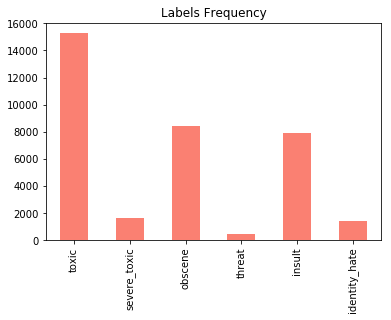

In [23]:
label_count.plot(kind='bar', title='Labels Frequency', color='salmon')

### Compare the imbalance between positive and negative comments in distribution

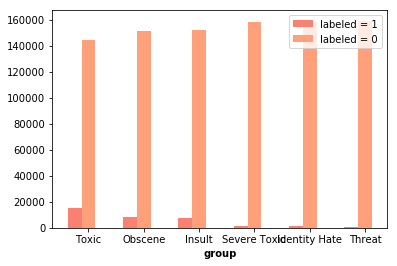

In [29]:
barWidth = 0.25

bars1 = [sum(train['toxic'] == 1), sum(train['obscene'] == 1), sum(train['insult'] == 1), sum(train['severe_toxic'] == 1),
         sum(train['identity_hate'] == 1), sum(train['threat'] == 1)]
bars2 = [sum(train['toxic'] == 0), sum(train['obscene'] == 0), sum(train['insult'] == 0), sum(train['severe_toxic'] == 0),
         sum(train['identity_hate'] == 0), sum(train['threat'] == 0)]


plt.bar(r1, bars1, color='salmon', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsalmon', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate',
                                                       'Threat'])
plt.legend()
plt.show()

### Find out the frequency of occurence of multilabelled data

In [32]:
# ct1,ct2 = 0,0
# for i in range(len(train_labels)):
#     ct = np.count_nonzero(train_labels[i])
#     if ct :
#         ct1 = ct1+1
#     if ct>1 :
#         ct2 = ct2+1
# print(ct1)
# print(ct2)
# # print("Non-negative comments : ",ct1)
# # print("Negative comments : ",ct2)

### Find Correlation among the different types of negative comments

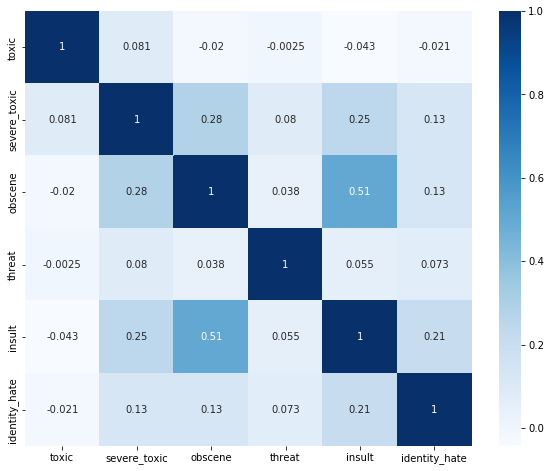

In [43]:
#remove the rows that have all colomns set to 0
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:]
train_corr = temp[rowsums > 0]
corr = train_corr.corr(method ='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

In [45]:
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:]
train_corr = temp[rowsums > 0]
print(rowsums)

0         0
1         0
2         0
3         0
4         0
5         0
6         4
7         0
8         0
9         0
10        0
11        0
12        1
13        0
14        0
15        0
16        1
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
159541    3
159542    0
159543    0
159544    0
159545    0
159546    2
159547    0
159548    0
159549    0
159550    0
159551    0
159552    0
159553    0
159554    3
159555    0
159556    0
159557    0
159558    0
159559    0
159560    0
159561    0
159562    0
159563    0
159564    0
159565    0
159566    0
159567    0
159568    0
159569    0
159570    0
Length: 159571, dtype: int64


### Preprocessing
#### Preprocessing involved the following steps, but these will be performed in a slightly different manner:

<ul>
    <li>Removing Punctuations and other special characters</li>
    <li>Splitting the comments into individual words</li>
    <li>Removing Stop Words</li>
    <li>Stemming and Lemmatising</li>
</ul>

In [46]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string 

#cleaning the data - lower the data, remove punctuations, remove numbers, filter non-ascii, remove stop words
def tokenize(text):
    stop_words = set(stopwords.words('english'))
    
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    
    filtered_sentence = []
    for w in words:
        if len(w) > 2:
            filtered_sentence.append(w)
    return filtered_sentence

In [47]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)
X_train = tfidf.fit_transform(train['comment_text'])

#we need to tranform the raw text of 'test' into float vectors bcz X_train is converted into vectors (not just fit but fit_transfor)
X_test = tfidf.transform(test['comment_text'])

In [48]:
tfidf.get_feature_names()[:20]

C:\Users\brs\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aaa',
 'aap',
 'aardvark',
 'aaron',
 'aba',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abbas',
 'abbey',
 'abbott',
 'abbreviated',
 'abbreviation',
 'abc',
 'abcnews',
 'abd',
 'abducted',
 'abduction',
 'abdul']

In [120]:
test_labels = ["toxic", "severe_toxic", "obscene",
               "threat", "insult", "identity_hate"]

def score(X_train, y_train, X_test, y_test):
    """
    Calculate Hamming-loss, F1, Recall for each label on test dataset.
    """
    methods = []
#     hloss = []
#     name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    hloss = []
    reports = []
    clf = LinearSVC()
    
    for label in test_labels:
        
        #fit and predict
        clf.fit(X_train, y_train[label])
        predicted = clf.predict(X_test)
        
        predict_df[label] = predicted
        
        
        #to extract rows w/o -1, we use indexing. refer https://www.geeksforgeeks.org/how-to-select-rows-from-a-dataframe-based-on-column-values/
        conf_mat = metrics.confusion_matrix(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1])
        
        recall = metrics.recall_score(y_test[y_test[label] != -1][label],
                              predicted[y_test[label] != -1],
                              average="weighted")
        
        f1 = metrics.f1_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1],
                      average="weighted")
        accuracy = metrics.accuracy_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1])

        methods.append([label, conf_mat])
        reports.append([label,recall,f1, accuracy])
     
    for label in test_labels:
        hamming_loss_score = metrics.hamming_loss(y_test[y_test[label] != -1].iloc[:, 1:7],
                                      predict_df[y_test[label] != -1].iloc[:, 1:7])
        hloss.append([label,hamming_loss_score])
    filename = 'saved_model.sav'
    pickle.dump(clf, open(filename, 'wb'))
        
    return methods, hloss, reports
        
   

In [121]:
methods= []
hloass = []
methods, hloss, reports= score(X_train, train, X_test, test_y)

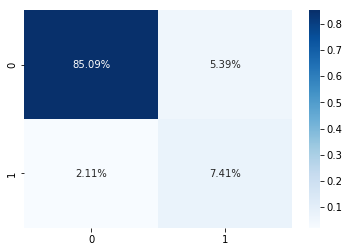

In [122]:
sns.heatmap(methods[0][1]/np.sum(methods[0][1]), annot=True, fmt='.2%', cmap='Blues')

In [123]:
methods

[['toxic',
  array([[54439,  3449],
         [ 1347,  4743]], dtype=int64)],
 ['severe_toxic',
  array([[63407,   204],
         [  245,   122]], dtype=int64)],
 ['obscene',
  array([[59125,  1162],
         [ 1217,  2474]], dtype=int64)],
 ['threat',
  array([[63688,    79],
         [  153,    58]], dtype=int64)],
 ['insult',
  array([[59581,   970],
         [ 1497,  1930]], dtype=int64)],
 ['identity_hate',
  array([[63133,   133],
         [  475,   237]], dtype=int64)]]

In [124]:
hloss

[['toxic', 0.028475934435795637],
 ['severe_toxic', 0.028475934435795637],
 ['obscene', 0.028475934435795637],
 ['threat', 0.028475934435795637],
 ['insult', 0.028475934435795637],
 ['identity_hate', 0.028475934435795637]]

In [125]:
df = pd.DataFrame(reports, columns=['label','recall', 'f1','Accuracy'])

In [126]:
df

,label,recall,f1,Accuracy
0,toxic,0.925037,0.929860,0.925037
1,severe_toxic,0.992982,0.992775,0.992982
2,obscene,0.962815,0.962684,0.962815
3,threat,0.996374,0.995989,0.996374
4,insult,0.961440,0.959917,0.961440
5,identity_hate,0.990497,0.989008,0.990497


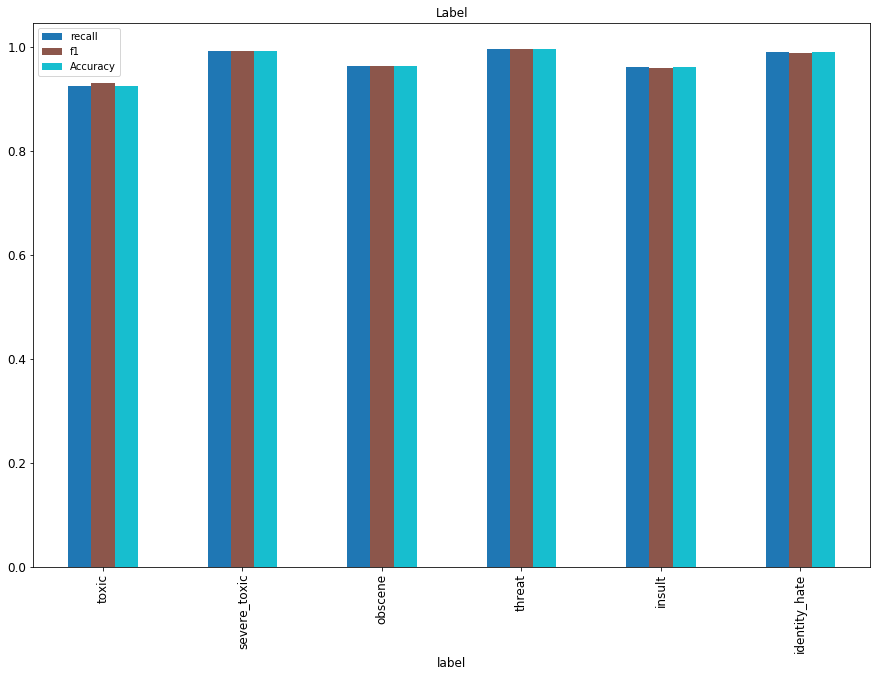

In [128]:
ax = df[['label','recall','f1','Accuracy']].plot( x='label',kind='bar', title ="Label", figsize=(15, 10), legend=True, fontsize=12, colormap='tab10')
ax.set_xlabel("label", fontsize=12)
plt.show()